Cargo los datos de la forma que muestra el enunciado de la consigna.

In [ ]:

from keras.datasets import mnist,fashion_mnist

(X_train_raw, y_train), (X_test_raw, y_test) = fashion_mnist.load_data()  # cargo los dataset de entrenamiento y testeo

# reshapeamos para obtener un vector de 784 elementos (features) por cada imagen (samples)
X_train = X_train_raw.reshape(60000, -1) # no tocamos el numero de samples, 60000, pero reshapeamos las demas dimensiones
X_test = X_test_raw.reshape(10000, -1) # no tocamos el numero de samples, 60000, pero reshapeamos las demas dimensiones

X_train = X_train.astype('float32') # transformamos el tipo de datos a "float32"
X_test = X_test.astype('float32') # transformamos el tipo de datos a "float32"

# normalizamos por el maximo valor que pueden tener los pixels para que los valores queden entre 0 y 1
X_train = X_train/255.0
X_test = X_test/255.0

# print the final input shape ready for training
print("Matriz de entrenamiento shape", X_train.shape)
print("Matriz de testeo shape", X_test.shape)

4431872/4422102 [==============================] - 0s 0us/step
Matriz de entrenamiento shape (60000, 784)
Matriz de testeo shape (10000, 784)


**Primer paso:** Hacer PCA sobre la matrix de datos de entrenamiento.

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

std_scale = StandardScaler()
std_scale.fit(X_train)
X_train_scaled = std_scale.transform(X_train)
X_test_scaled = std_scale.transform(X_test)
pca = PCA(n_components=None)
pca.fit(X_train_scaled)
X_pca = pca.transform(X_train_scaled)

print('Dimensiones de la matriz en componentes principales: {}'.format(X_pca.shape))
print(X_pca)


Dimensiones de la matriz en componentes principales: (60000, 784)
[[-8.0117321e-01  2.0866760e+01 -1.2945171e+01 ... -1.1026844e-01
  -1.4078691e-02  5.9457563e-02]
 [ 1.7074207e+01 -4.9685173e+00 -2.0778544e+00 ...  1.4396225e-02
  -8.7959655e-03 -6.5454561e-03]
 [-9.6016407e+00 -1.2296110e+01  1.0822548e+00 ...  3.1704009e-03
   7.9233544e-03  1.4937655e-02]
 ...
 [ 9.3776636e+00 -1.3105858e+01 -8.8382721e+00 ...  2.7277462e-02
  -4.5000674e-04  5.0364994e-04]
 [-9.6456366e+00 -7.0952973e+00  6.9453030e+00 ...  4.7226455e-03
   7.9852100e-03 -1.8133090e-03]
 [-2.1317078e+01 -1.7413688e+00  5.4762945e+00 ... -1.0378803e-01
  -1.7314008e-02 -1.0174326e-02]]


**Segundo paso:** Obtener y plotear la varianza explicada por cada componente y la varianza explicada acumulada vs. número de componentes.

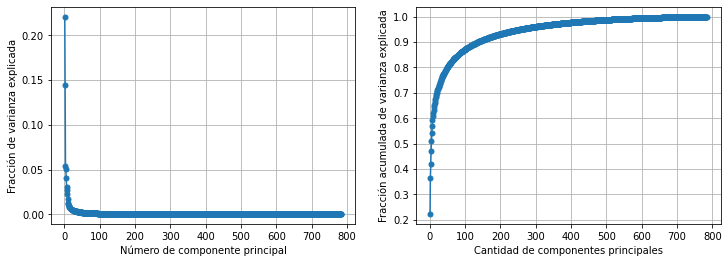

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

evr = pca.explained_variance_ratio_
fig, ax = plt.subplots(1, 2, figsize = (12, 4))

ax[0].plot(range(1, len(evr) + 1), evr, '.-', markersize = 10)
ax[0].set_ylabel('Fracción de varianza explicada')
ax[0].set_xlabel('Número de componente principal')
ax[0].grid()

varianza_acumulada = np.cumsum(evr)

ax[1].plot(range(1, len(evr) + 1), varianza_acumulada, '.-', markersize = 10)
ax[1].set_ylabel('Fracción acumulada de varianza explicada')
ax[1].set_xlabel('Cantidad de componentes principales')
ax[1].grid()

**Tercer paso:** Visualizar las primeros cinco componentes en orden de varianza explicada

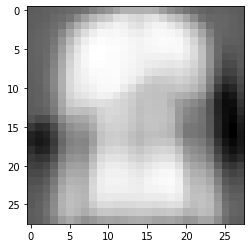

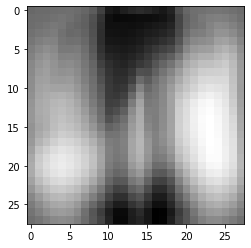

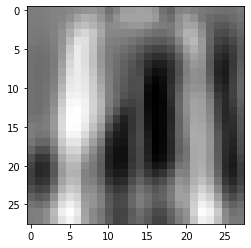

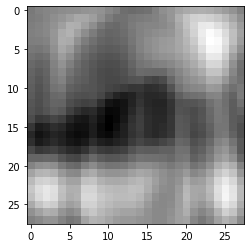

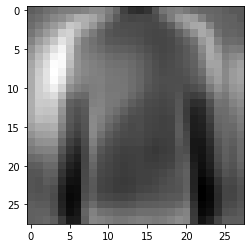

In [ ]:

for i in range(5):
  plt.imshow(pca.components_[i].reshape(28,28), interpolation='none', cmap="gray")
  plt.show()

**Cuarto paso:** Elegir algunas de las imágenes al azar y mostrar la reconstrucción obtenida usando 2, 10, 25, 50 y 100 componentes.

---



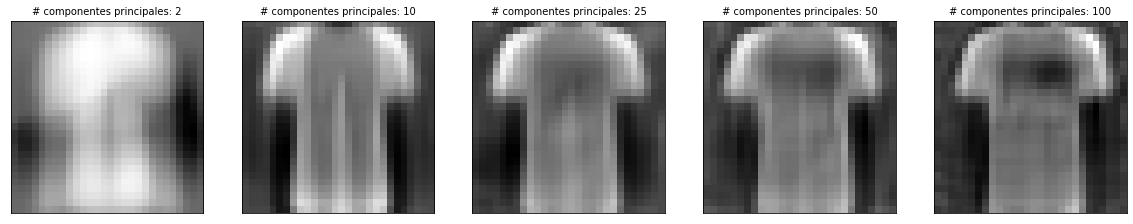

In [ ]:
fig, ax = plt.subplots(1, 5, figsize = (20, 10))
fig_index = 0 

for p in [2, 10, 25, 50, 100]:

  pca = PCA(n_components = p)

  pca.fit(X_train_scaled)
  X_pca = pca.transform(X_train_scaled)

  X_r = pca.inverse_transform(X_pca)

  ax[fig_index].imshow(X_r[1, :].reshape(28, 28), interpolation='none', cmap="gray")
  ax[fig_index].set_title("# componentes principales: {}".format(p), fontsize = 10)
  ax[fig_index].set_xticks([]) 
  ax[fig_index].set_yticks([]) 

  fig_index += 1

plt.show()

**Quinto paso:** Visualizar los datos en un espacio de dimensión reducida formado por la 1era vs. la 2da componentes principales, usando scatterplot.

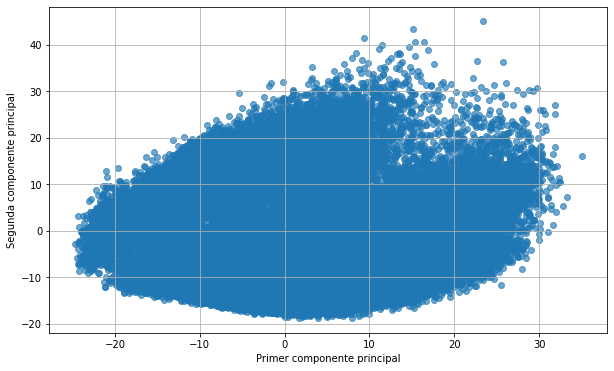

In [ ]:
fig, ax = plt.subplots(figsize = (10, 6))

ax.scatter(X_pca[:,0], X_pca[:,1], alpha = 0.65)
ax.set_xlabel('Primer componente principal')
ax.set_ylabel('Segunda componente principal')
ax.grid()

**Sexto paso:** Hacer k-means con k=2 sobre los datos del espacio 2D formado por la primera y segunda componente principal. Visualizar algunos ejemplos correspondientes a cada uno de los clusters para entender a dónde fue a parar cada tipo de prenda en los clusters.

[1 0 1 ... 0 1 1]


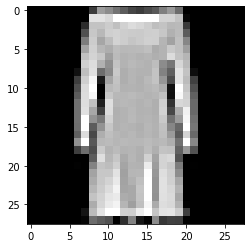

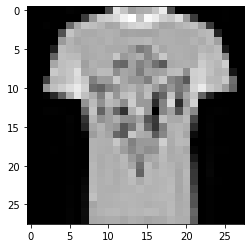

In [ ]:
from sklearn.cluster import KMeans

pca = PCA(n_components = 2)
pca.fit(X_train_scaled)
X_pca = pca.transform(X_train_scaled)

kmeans = KMeans(n_clusters=2)
kmeans.fit(X_pca)

print(kmeans.labels_)
plt.imshow(X_test[5998].reshape(28,28), interpolation='none', cmap="gray")
plt.show()
plt.imshow(X_test[5999].reshape(28,28), interpolation='none', cmap="gray")
plt.show()

**Séptimo paso:** Usando los ids del clustering como etiquetas, entrenar un modelo KNN (K=5) usando los datos de entrenamiento (con todos los features, no solo las primeras dos componentes principales).

In [ ]:

from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from random import shuffle

clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(X_train_scaled, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

**Octavo paso:** Armar un nuevo vector de etiquetas que reemplace a y_test, y tenga 0 donde pensamos que ese ejemplo iría al cluster 0 y 1 donde pensamos que iría al cluster 1 (los clusters que obtuvimos con k-means).

In [ ]:
y_test2=[]

for i in range(len(y_test)):
  if y_test[i] in [5,7,8,9]:
    y_test2 += [0]
  else:
    y_test2 += [1]

print(y_test2)

[0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 

**Noveno paso:** Ahora aplicar el modelo KNN a datos del dataset de evaluación. Hacerlo con los primeros 1000 (sino puede tardar mucho). Usando las ids obtenidas mediante el procedimiento del paso anterior, y las predichas por KNN, construir una matriz de confusión para evaluar la performance del clasificador KNN.

In [ ]:
y_test2 = np.array(y_test2)
y_pred = clf.predict(X_test_scaled[:100]) #Aplico el modelo para los primeros 100 datos. Porque aún con 1000 tarda demasiado.
from sklearn.metrics import confusion_matrix as cm
conf_mat = cm(y_test2[:100], y_pred[:100])
print(conf_mat)

[[ 0  0  0  0  0  8  0 11 12  7]
 [10 13 15  6  8  0 10  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]]
